In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [2]:
img_width=256; img_height=256
batch_size=8
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1274 images belonging to 5 classes.


In [3]:
VALIDATION_DIR = '../weather_pred/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [4]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '.../VGG16_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [6]:
vgg16_base = VGG16(include_top=False, weights='imagenet',
                   input_tensor=None, input_shape=(img_height, img_width, 3))

58900480/58889256 [==============================] - 17s 0us/step


In [7]:
print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [8]:
vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])
history = vgg16_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_12364\1586418889.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 29s 162ms/step - loss: 1.0058 - accuracy: 0.7488 - val_loss: 0.8781 - val_accuracy: 0.8584
Epoch 2/30
160/160 [==============================] - 20s 123ms/step - loss: 0.5759 - accuracy: 0.8516 - val_loss: 0.3770 - val_accuracy: 0.9204
Epoch 3/30
160/160 [==============================] - 20s 121ms/step - loss: 0.5030 - accuracy: 0.8516 - val_loss: 0.4946 - val_accuracy: 0.9027
Epoch 4/30
160/160 [==============================] - 19s 119ms/step - loss: 0.3862 - accuracy: 0.8948 - val_loss: 0.3498 - val_accuracy: 0.9248
Epoch 5/30
160/160 [==============================] - 19s 121ms/step - loss: 0.3738 - accuracy: 0.8854 - val_loss: 0.3713 - val_accuracy: 0.9336
Epoch 6/30
160/160 [==============================] - 19s 121ms/step - loss: 0.3615 - accuracy: 0.8862 - val_loss: 0.3116 - val_accuracy: 0.9292
Epoch 7/30
160/160 [==============================] - 19s 119ms/step - loss: 0.3102 - accuracy: 0.9066 - val_loss: 0.2631 - val_ac

In [11]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg16_model.save(target_dir + 'vgg16_model_256.h5')
vgg16_model.save_weights(target_dir + 'vgg16_weights_256.h5')

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

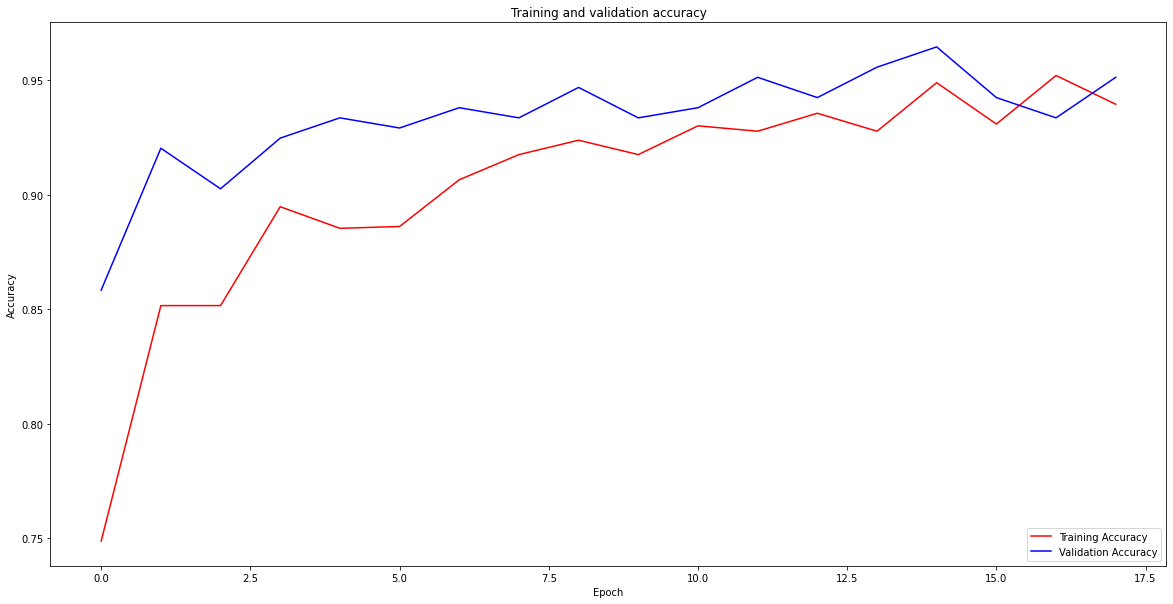

In [15]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Accuracy_curve_vgg16_drop_batch_256.jpg')

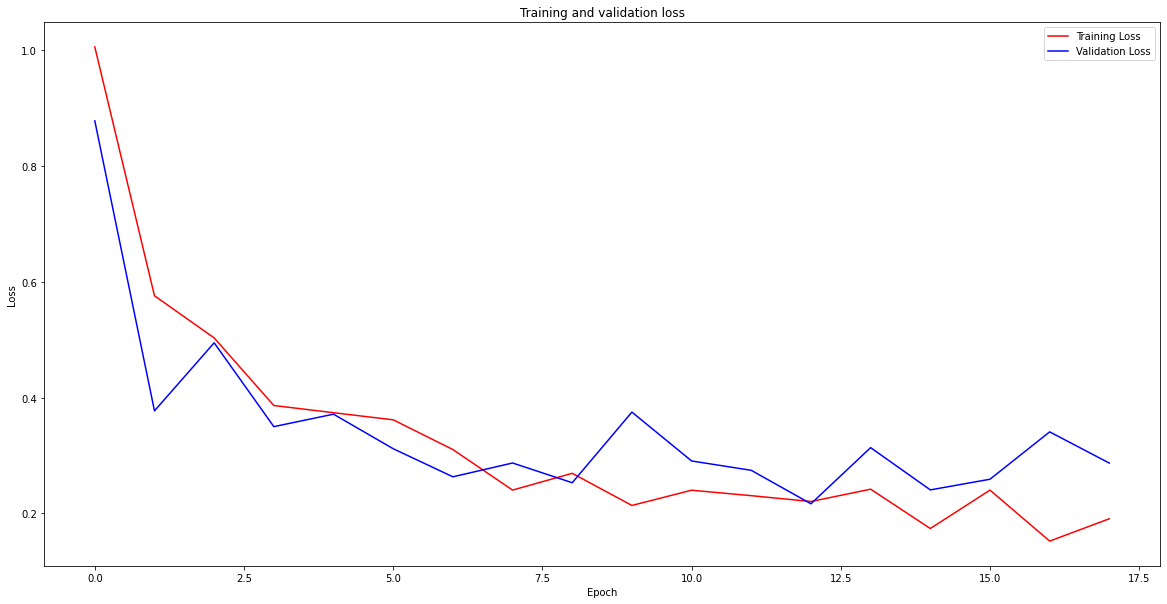

In [16]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
fig2.savefig('Loss_curve_vgg16_drop_batch_256.jpg')

In [17]:
import numpy as np
test_preprocessed_images = np.load('../test_preproc_res-net.npy')


In [18]:
#Prediction Function
array = vgg16_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

30/30 [==============================] - 1s 11ms/step


In [19]:
import pandas as pd
test_df = pd.read_csv('../dataset/test.csv')
y_true = test_df['labels']

In [20]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


In [33]:
train_dir = '../weather_pred/Data/training/'
classes = os.listdir(train_dir)

In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        
    else:
        cm=cm
        
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

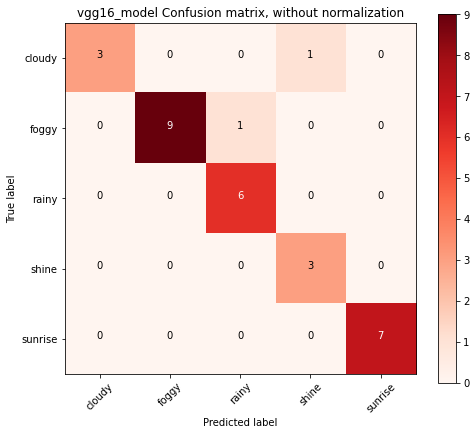

In [34]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='vgg16_model Confusion matrix, without normalization')
plt.show()

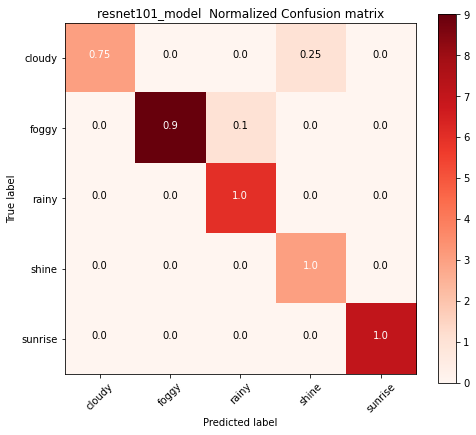

In [35]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='resnet101_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      cloudy       1.00      0.75      0.86         4
       foggy       1.00      0.90      0.95        10
       rainy       0.86      1.00      0.92         6
       shine       0.75      1.00      0.86         3
     sunrise       1.00      1.00      1.00         7

    accuracy                           0.93        30
   macro avg       0.92      0.93      0.92        30
weighted avg       0.95      0.93      0.93        30



In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9333333333333333

In [38]:
from tensorflow.keras.applications.vgg19 import VGG19

In [39]:
callbacks2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file2 = '.../weather_pred/vgg19_drop_batch_best_weights_256.h5'
best_model2 = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [40]:
vgg19_base = VGG19(include_top=False, weights='imagenet',
                   input_tensor=None, input_shape=(img_height, img_width, 3))


80150528/80134624 [==============================] - 23s 0us/step


In [41]:
print('Adding new layers...')
output = vgg19_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
# and a logistic layer -- let's say we have 4 classes
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [42]:
vgg19_model = Model(vgg19_base.input, output)
for layer in vgg19_model.layers[:-7]:
    layer.trainable = False

vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [43]:
vgg19_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [45]:
history2 = vgg19_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_12364\2445951031.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = vgg19_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 19s 121ms/step - loss: 0.5025 - accuracy: 0.8399 - val_loss: 0.3049 - val_accuracy: 0.9027
Epoch 2/30
160/160 [==============================] - 20s 123ms/step - loss: 0.3675 - accuracy: 0.8776 - val_loss: 0.2962 - val_accuracy: 0.9248
Epoch 3/30
160/160 [==============================] - 19s 121ms/step - loss: 0.3411 - accuracy: 0.8893 - val_loss: 0.2272 - val_accuracy: 0.9336
Epoch 4/30
160/160 [==============================] - 20s 123ms/step - loss: 0.3490 - accuracy: 0.8846 - val_loss: 0.2198 - val_accuracy: 0.9336
Epoch 5/30
160/160 [==============================] - 19s 120ms/step - loss: 0.2579 - accuracy: 0.9129 - val_loss: 0.2433 - val_accuracy: 0.9292
Epoch 6/30
160/160 [==============================] - 20s 123ms/step - loss: 0.2450 - accuracy: 0.9113 - val_loss: 0.1831 - val_accuracy: 0.9381
Epoch 7/30
160/160 [==============================] - 19s 121ms/step - loss: 0.2272 - accuracy: 0.9333 - val_loss: 0.2310 - val_ac

Epoch 28/30
160/160 [==============================] - 19s 119ms/step - loss: 0.1399 - accuracy: 0.9513 - val_loss: 0.1889 - val_accuracy: 0.9381
Epoch 29/30
160/160 [==============================] - 20s 122ms/step - loss: 0.1244 - accuracy: 0.9568 - val_loss: 0.1964 - val_accuracy: 0.9690
Epoch 30/30
160/160 [==============================] - 19s 121ms/step - loss: 0.1279 - accuracy: 0.9560 - val_loss: 0.4463 - val_accuracy: 0.9558


In [47]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg19_model.save(target_dir + 'vgg19_model.h5')
vgg19_model.save_weights(target_dir + 'vgg19_weights.h5')

In [48]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc))

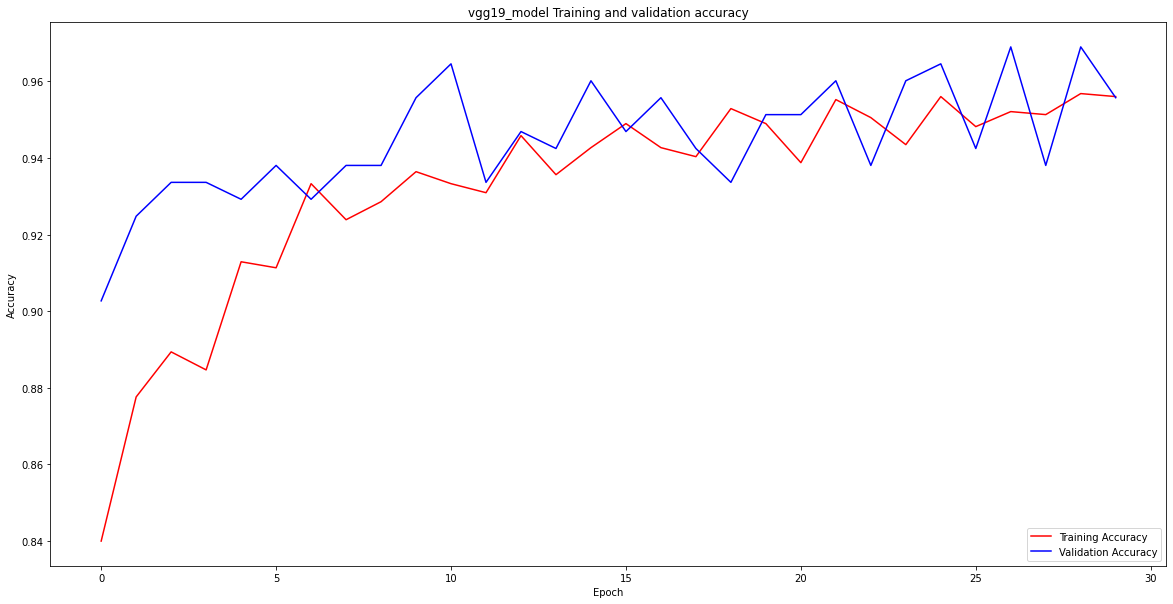

In [49]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('vgg19_model Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('vgg19_model.jpg')

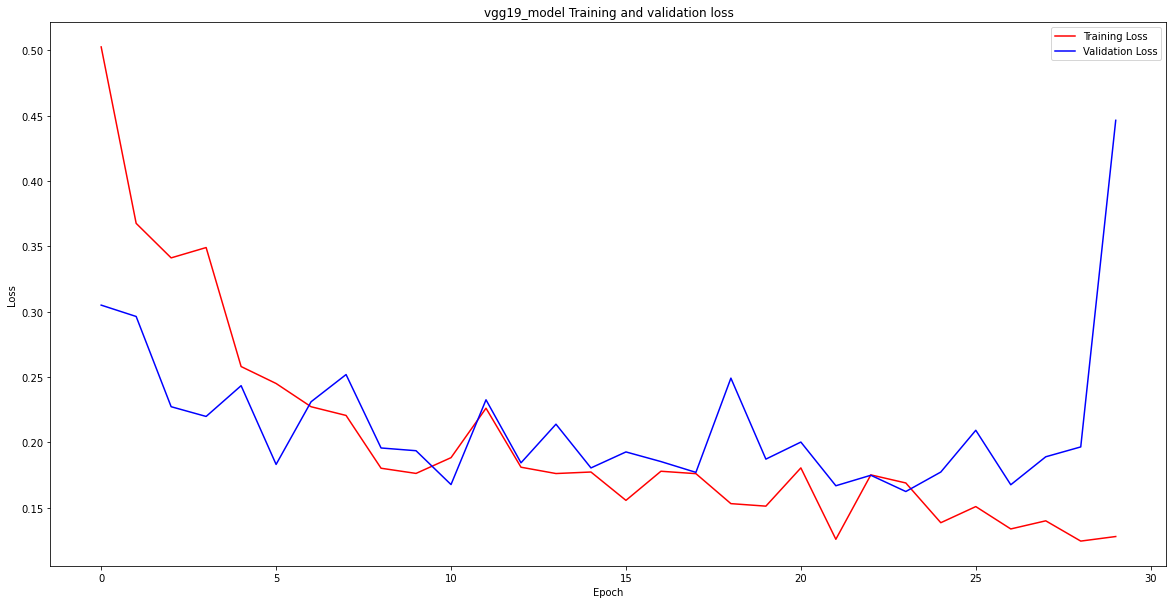

In [50]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('vgg19_model Training and validation loss')
fig2.savefig('vgg19_model.jpg')


In [51]:
#Prediction Function
array2 = vgg19_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred2 = np.argmax(array2, axis=1)

30/30 [==============================] - 1s 14ms/step


In [52]:
from sklearn.metrics import confusion_matrix
conf_mat2 = confusion_matrix(y_true, y_pred2)


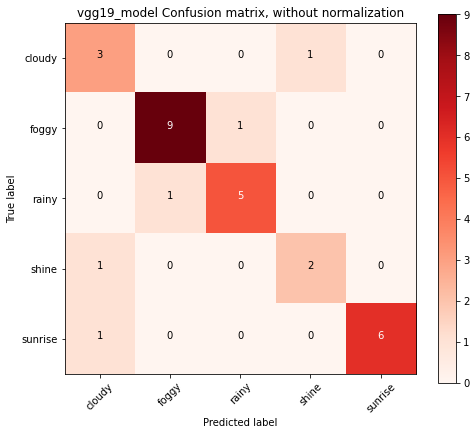

In [53]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat2, classes=classes, title='vgg19_model Confusion matrix, without normalization')
plt.show()

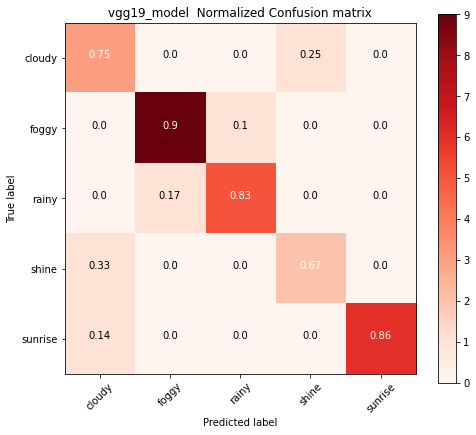

In [54]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat2, classes=classes, normalize = True, title='vgg19_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [55]:
print(classification_report(y_true, y_pred2, target_names=classes))

              precision    recall  f1-score   support

      cloudy       0.60      0.75      0.67         4
       foggy       0.90      0.90      0.90        10
       rainy       0.83      0.83      0.83         6
       shine       0.67      0.67      0.67         3
     sunrise       1.00      0.86      0.92         7

    accuracy                           0.83        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.85      0.83      0.84        30



In [56]:
accuracy_score(y_true, y_pred2)

0.8333333333333334